<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 69 (delta 25), reused 35 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 2.49 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/decentralized-ai-content-recommender
Node 1 Dataset Overview:
Total samples: 2784

Category distribution:
category
ai       928
music    928
web3     928
Name: count, dtype: int64

Node 1 Training Data:
Training data shape: (2227, 305)
Testing data shape: (557, 305)
Class weights: {0: 1.0004492362982929, 1: 0.9991027366532077, 2: 1.0004492362982929}
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4288 - loss: 3.9247 - val_accuracy: 0.5179 - val_loss: 3.1055 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6357 - loss: 2.8884 - val_accuracy: 0.6502 - val_loss:

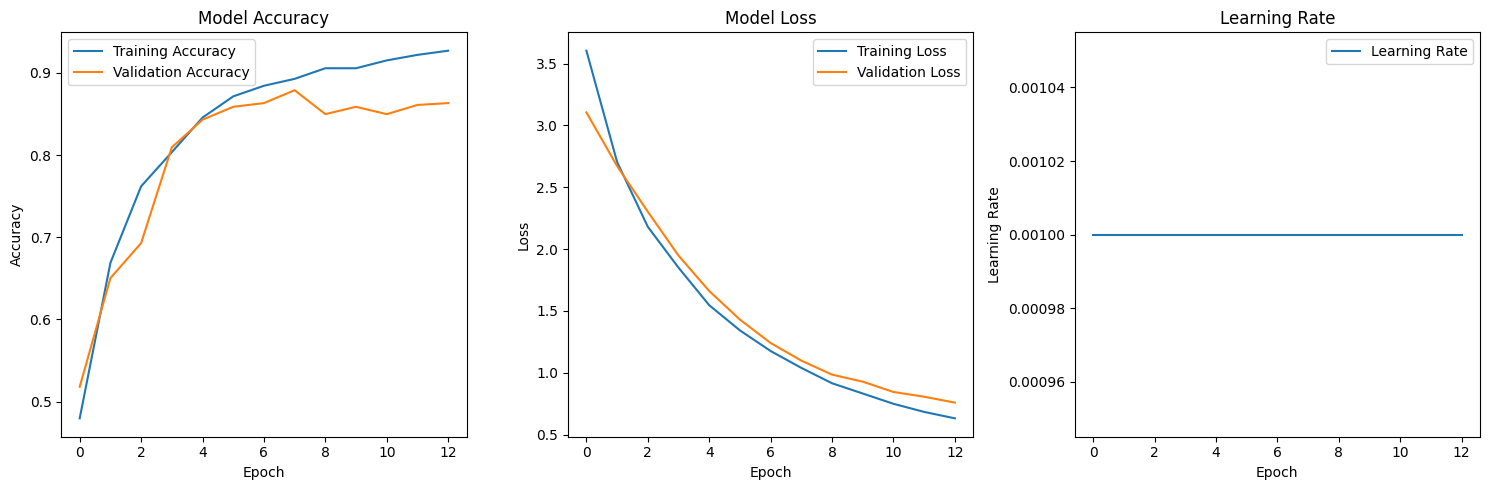


Final Results:
Training Accuracy: 0.9270
Validation Accuracy: 0.8789
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 1.1158 
Test Accuracy: 0.8725
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Detailed Classification Report:
              precision    recall  f1-score   support

          ai       0.88      0.83      0.85       186
       music       0.83      0.93      0.88       185
        web3       0.91      0.86      0.89       186

    accuracy                           0.87       557
   macro avg       0.88      0.87      0.87       557
weighted avg       0.88      0.87      0.87       557



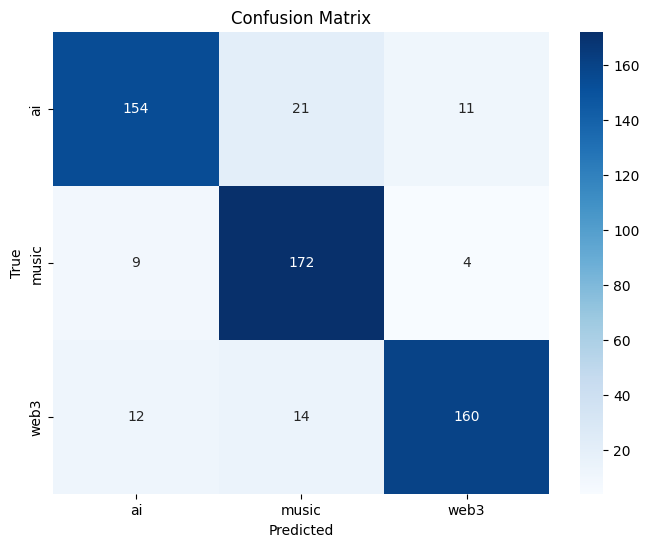

In [2]:
# Cell 1: Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

# Install required packages
!pip install flwr tensorflow pandas scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import flwr as fl
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Cell 2: Improved Data Loading and Preprocessing
def preprocess_text(text):
    """Basic text preprocessing"""
    if not isinstance(text, str):
        return ''

    # Convert to lowercase and basic cleaning
    text = text.lower()
    # Remove special characters and extra spaces
    text = ' '.join(text.split())
    return text

def load_node_data(node_number=1):
    """Load balanced data for each node"""
    # Load all datasets
    datasets = {
        'ai': pd.read_csv('data/raw/reddit_analysis_ai_with_sentiment.csv'),
        'music': pd.read_csv('data/raw/reddit_analysis_music_with_sentiment.csv'),
        'web3': pd.read_csv('data/raw/reddit_analysis_web3_with_sentiment.csv')
    }

    # Get the minimum size among all datasets
    min_size = min(len(df) for df in datasets.values())

    # Sample equally from each dataset
    balanced_dfs = []
    for category, df in datasets.items():
        sampled_df = df.sample(n=min_size, random_state=42+node_number)
        sampled_df['category'] = category
        balanced_dfs.append(sampled_df)

    # Combine datasets
    df = pd.concat(balanced_dfs, ignore_index=True)

    # Basic text preprocessing
    df['cleaned_title'] = df['title'].apply(preprocess_text)
    df['cleaned_content'] = df['cleaned_text'].apply(preprocess_text)
    df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_content']

    # Create derived features
    df['score_log'] = np.log1p(df['score'])
    df['comments_log'] = np.log1p(df['num_comments'])
    df['text_word_count'] = df['combined_text'].str.split().str.len()

    # Enhanced sentiment features
    df['sentiment_compound'] = (df['textblob_sentiment'] + df['transformer_score']) / 2
    df['sentiment_magnitude'] = abs(df['textblob_sentiment'])

    # Normalize numerical features
    numerical_cols = ['score_log', 'comments_log', 'text_word_count',
                     'sentiment_compound', 'sentiment_magnitude']

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Print node info
    print(f"Node {node_number} Dataset Overview:")
    print(f"Total samples: {len(df)}")
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    return df

# Cell 3: Improved Node Client Implementation
class NodeClient(fl.client.NumPyClient):
    def __init__(self, df, node_number):
        """Initialize node client with dataset"""
        self.df = df
        self.node_number = node_number
        self.prepare_data()
        self.model = self.create_model()

    def prepare_data(self):
        """Prepare features and labels with improved vectorization"""
        # Create text features with reduced complexity
        self.vectorizer = TfidfVectorizer(
            max_features=300,  # Further reduced features
            stop_words='english',
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95
        )
        X_text = self.vectorizer.fit_transform(self.df['combined_text']).toarray()

        # Add numerical features
        numerical_features = ['score_log', 'comments_log', 'text_word_count',
                            'sentiment_compound', 'sentiment_magnitude']
        X_numerical = self.df[numerical_features].fillna(0).values

        # Combine features
        self.X = np.hstack([X_text, X_numerical])

        # Prepare labels
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.df['category'])

        # Split data with stratification
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=0.2,
                           stratify=self.y,
                           random_state=42+self.node_number)

        # Compute class weights
        self.class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weights = dict(enumerate(self.class_weights))

        print(f"\nNode {self.node_number} Training Data:")
        print(f"Training data shape: {self.X_train.shape}")
        print(f"Testing data shape: {self.X_test.shape}")
        print("Class weights:", self.class_weights)

    def create_model(self):
        """Create simplified neural network model"""
        model = tf.keras.Sequential([
            # Input layer
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=(self.X_train.shape[1],),
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Hidden layer
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Output layer
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def get_parameters(self, config):
        """Get model parameters"""
        return [np.array(layer.get_weights()) for layer in self.model.layers]

    def fit(self, parameters, config):
        """Train model with improved parameters"""
        for layer, layer_weights in zip(self.model.layers, parameters):
            layer.set_weights(layer_weights)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True,
                min_delta=0.005
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.0001
            )
        ]

        history = self.model.fit(
            self.X_train,
            self.y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            class_weight=self.class_weights,
            verbose=1
        )

        return (
            self.get_parameters(config),
            len(self.X_train),
            {"loss": history.history["loss"][-1],
             "accuracy": history.history["accuracy"][-1]}
        )

    def evaluate(self, parameters, config):
        """Evaluate model"""
        for layer, layer_weights in zip(self.model.layers, parameters):
            layer.set_weights(layer_weights)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        return loss, len(self.X_test), {"accuracy": accuracy}

# Cell 4: Train and Evaluate Node 1
# Load balanced data
node1_df = load_node_data(node_number=1)

# Initialize client
node1 = NodeClient(node1_df, node_number=1)

# Train and monitor
history = node1.model.fit(
    node1.X_train,
    node1.y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=node1.class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            min_delta=0.005
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.0001
        )
    ],
    verbose=1
)

# Plot detailed results
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning rate plot
plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation and analysis
print("\nFinal Results:")
print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# Test set evaluation
test_loss, test_accuracy = node1.model.evaluate(node1.X_test, node1.y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
y_pred = node1.model.predict(node1.X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nDetailed Classification Report:")
print(classification_report(node1.y_test, y_pred_classes,
                          target_names=node1.label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(node1.y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=node1.label_encoder.classes_,
            yticklabels=node1.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()